# Confounding Effects on Reddit: `/r/PC` and `/r/PCM`
- To replicate: **Figure A.2**

In [1]:
# Packages
import ast
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
from tqdm import tqdm
import sys

sys.path += ['../']

from config import processed_data_path, raw_data_path, figure_path

# Parameters
DATA_PATH = raw_data_path
FIGURES_PATH = figure_path
OUTPUT_PATH = processed_data_path

SUBREDDITS = {
    'PoliticalCompass': 'PC',
    'PoliticalCompassMemes': 'PCM'}

# Plot style
sns.set_context('talk', rc={'font.size': 14.0,
                            'axes.labelsize': 14.0,
                            'axes.titlesize': 14.0,
                            'xtick.labelsize': 12.0,
                            'ytick.labelsize': 12.0,
                            'legend.fontsize': 12.0,
                            'legend.title_fontsize': 16.0,
                            'patch.linewidth': 1.5,
                            'font.family': 'serif',
                            'font.serif': 'Linux Libertine O',
                           }
               )

# Functions
def distr_bin(data, n_bin=30, logbin=True, namefile=''):
    # Function for plotting in a proper way histograms (from Michele)
    ''' Logarithmic binning of raw positive data;
        Input:
            data = np array,
            bins= number if bins,
            logbin = if true log bin
        Output (array: bins, array: hist)
        bins: centred bins
        hist: histogram value / (bin_length * num_el_data) [nonzero]
    '''
    if len(data) == 0:
        print("Error empty data\n")
        
    min_d = float(min(data))
    if logbin and min_d <= 0:
        print ("Error nonpositive data\n")
        
    n_bin = float(n_bin) # Ensure float values
    bins = np.arange(n_bin+1)
    
    if logbin:
        data = np.array(data) / min_d
        base= np.power(float(max(data)) , 1.0 / n_bin)
        bins = np.power(base,bins)
        bins = np.ceil(bins) # To avoid problem for small ints
    else:
        data = np.array(data) + min_d # To include negative data
        delta = (float(max(data)) - float(min(data))) / n_bin
        bins = bins * delta + float(min(data))
        
    n_bin = int(n_bin)
    #print (‘first bin: ’,bins[0],‘first data:’,min(data),‘max bin:’,bins[n_bin],‘max data’,float(max(data)))
    hist = np.histogram(data, bins)[0]
    ii = np.nonzero(hist)[0] # Take non zero values of histogram
    bins = bins[ii]
    hist = hist[ii]
    bins = np.append(bins,float(max(data))) # Append the last bin
    bin_len = np.diff(bins)
    bins = bins[:-1] + bin_len / 2.0 # Don’t return last bin, centred boxes
    
    if logbin:
        hist = hist / bin_len # Normalize values
        bins = bins * min_d # Restore original bin values
    else:
        bins = bins - min_d
        
    res = list(zip(bins, hist / float(sum(hist)))) # Restore original bin values, norm hist
    if len(namefile) > 0:
        np.savetxt(namefile,res)
    return list(zip(*res))

# Functions
def num_comm(row):
    """
    Calculates the number of comments in a row of the DataFrame.
    Args:
        row (pd.Series): A row of the DataFrame.
    Returns:
        int: The number of comments in the row.
    """
    return len(row['scores'])

def avg_score(row):
    """
    Calculates the average score in a row of the DataFrame.
    Args:
        row (pd.Series): A row of the DataFrame.
    Returns:
        float: The average score in the row.
    """
    return round(np.mean(row['scores']), 4)

def stddev_score(row):
    """
    Calculates the standard deviation of the scores in a row of the DataFrame.
    Args:
        row (pd.Series): A row of the DataFrame.
    Returns:
        float: The standard deviation of the scores in the row.
    """
    return round(np.std(row['scores']), 4)

def num_comm_pos(row):
    """
    Calculates the number of positive comments in a row of the DataFrame.
    Args:
        row (pd.Series): A row of the DataFrame.
    Returns:
        int: The number of positive comments in the row.
    """
    return len([score for score in row["scores"] if score > 0])

def avg_score_pos(row):
    """
    Calculates the average of the positive comments in a row of the DataFrame.
    Args:
        row (pd.Series): A row of the DataFrame.
    Returns:
        float: The average of the positive comments in the row.
    """
    pos_comm = num_comm_pos(row)
    if pos_comm > 0:
        return round(np.mean([score for score in row["scores"] if score > 0]), 4)
    else:
        return 0

def stddev_score_pos(row):
    """
    Calculates the standard deviation of the positive comments in a row of the DataFrame.
    Args:
        row (pd.Series): A row of the DataFrame.
    Returns:
        float: The standard deviation of the positive comments in the row.
    """
    pos_comm = num_comm_pos(row)
    if pos_comm > 0:
        return round(np.std([score for score in row["scores"] if score > 0]), 4)
    else:
        return 0

def num_comm_neg(row):
    """
    Calculates the number of negative comments in a row of the DataFrame.
    Args:
        row (pd.Series): A row of the DataFrame.
    Returns:
        int: The number of negative comments in the row.
    """
    return len([score for score in row["scores"] if score < 0])

def avg_score_neg(row):
    """
    Calculates the average of the negative comments in a row of the DataFrame.
    Args:
        row (pd.Series): A row of the DataFrame.
    Returns:
        float: The average of the negative comments in the row.
    """
    neg_comm = num_comm_neg(row)
    if neg_comm > 0:
        return round(np.mean([score for score in row["scores"] if score < 0]), 4)
    else:
        return 0

def stddev_score_neg(row):
    """
    Calculates the standard deviation of the negative comments in a row of the DataFrame.
    Args:
        row (pd.Series): A row of the DataFrame.
    Returns:
        float: The standard deviation of the negative comments in the row.
    """
    neg_comm = num_comm_neg(row)
    if neg_comm > 0:
        return round(np.std([score for score in row["scores"] if score < 0]), 4)
    else:
        return 0
    
def popularity_metrics(df, across_years=False):
    """
    Calculates popularity metrics for a DataFrame of comments.
    Args:
        df (pd.DataFrame): The DataFrame of comments.
        across_years (bool): Whether to calculate popularity metrics across all years or for each year separately.
    Returns:
        pd.DataFrame: The DataFrame with the popularity metrics added.
    """
    # Convert the scores column to a list of scores.
    scores = df['scores'].apply(lambda x: ast.literal_eval(x))
    df['scores'] = scores

    # If across_years is True, group the DataFrame by author and aggregate the scores.
    if across_years:
        df = df.groupby('author').agg(sum)

    # Calculate the popularity metrics.
    df['num_comm'] = df.apply(num_comm, axis=1)
    df['avg_score'] = df.apply(avg_score, axis=1)
    df['stddev_score'] = df.apply(stddev_score, axis=1)
    df['num_comm_pos'] = df.apply(num_comm_pos, axis=1)
    df['avg_score_pos'] = df.apply(avg_score_pos, axis=1)
    df['stddev_score_pos'] = df.apply(stddev_score_pos, axis=1)
    df['num_comm_neg'] = df.apply(num_comm_neg, axis=1)
    df['avg_score_neg'] = df.apply(avg_score_neg, axis=1)
    df['stddev_score_neg'] = df.apply(stddev_score_neg, axis=1)

    # Drop the scores column.
    df = df.drop(columns=['scores']).reset_index()

    return df

## 0. Load data

In [2]:
# Load data
users = {}
edges = {}
confounding = {}

for S in SUBREDDITS:

    # Users with single flair
        # columns: author, flair
    users[S] = pd.read_csv(OUTPUT_PATH + f"single_flair_anonymized_users_{SUBREDDITS[S]}.csv")
    print(f"{S}:")
    print(f"\tUsers loaded ✓")
    
    # Edges from Interaction Network
        # columns: parent, child, sentiment

    edges[S] = pd.read_csv(DATA_PATH + f"edges_anonymized_{SUBREDDITS[S]}.csv")
    edges[S] = edges[S][['child', 'parent']]
    print(f"\tEdges loaded ✓")
    
    # Confounding metrics
        # columns: author, scores

    confounding[S] = pd.read_csv(DATA_PATH + f"popularity_anonymized_{SUBREDDITS[S]}.csv")
    print(f"\tConfounding values loaded ✓")

PoliticalCompass:
	Users loaded ✓
	Edges loaded ✓
	Confounding values loaded ✓
PoliticalCompassMemes:
	Users loaded ✓
	Edges loaded ✓
	Confounding values loaded ✓


## 0.1 Pre-processing popularity metrics

In [3]:
for S in SUBREDDITS.keys():
    print(f"{S}:")
    
    confounding[S] = popularity_metrics(confounding[S], across_years=True)
    print(f"\tPopularity metrics get ✓")

PoliticalCompass:


/tmp/ipykernel_1230326/3535381942.py:216: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby('author').agg(sum)


	Popularity metrics get ✓
PoliticalCompassMemes:


/tmp/ipykernel_1230326/3535381942.py:216: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby('author').agg(sum)


	Popularity metrics get ✓


## 1. Confounding metrics: activity and popularity

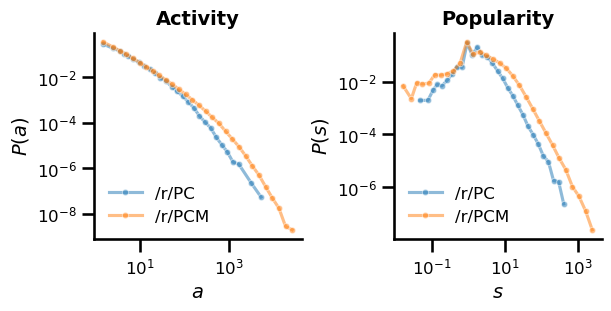

In [4]:
fig = plt.figure(layout='constrained', figsize=(6,3))
ax = fig.subplot_mosaic("""
AB
""")

plot_order = {'Activity': 'A',
              'Popularity': 'B'}
params = {'Activity': ('num_comm', 'a'),
          'Popularity': ('avg_score', 's')}

colors = {
    'PoliticalCompass': 'tab:blue',
    'PoliticalCompassMemes': 'tab:orange'
}

for S in SUBREDDITS:
    for T in ['Activity', 'Popularity']:
        bins_val, hist_val = distr_bin(np.array(confounding[S]
                                                [confounding[S][params[T][0]] > 0][params[T][0]]
                                               )
                                      )
        sns.lineplot(x=bins_val, y=hist_val,
                     ax=ax[plot_order[T]],
                     zorder=3,
                     marker='.',
                     alpha=0.5,
                     color=colors[S],
                     label=f'/r/{SUBREDDITS[S]}'
                    )
        ax[plot_order[T]].set_xscale('log')
        ax[plot_order[T]].set_yscale('log')
        ax[plot_order[T]].set_xlabel(f'${params[T][1]}$')

        ax[plot_order[T]].legend(framealpha=0)
        ax[plot_order[T]].set_title(T, weight='bold')
        
        sns.despine(right=True)
        
        if plot_order[T] == 'A':
            ax['A'].set_ylabel(f'$P(a)$')
        else:
            ax['B'].set_ylabel(f'$P(s)$')

plt.savefig(FIGURES_PATH + '0_2_activity_popularity.pdf', bbox_inches='tight')
plt.show()

## 2. Save data

In [5]:
for S in SUBREDDITS.keys():
    confounding[S].to_csv(OUTPUT_PATH + f"popularity_metrics_anonymized_{SUBREDDITS[S]}.csv", index=False, header=True)